In [1]:
import tensorflow as tf

In [2]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [3]:
keras = tf.keras

In [4]:
#base_model =tf.keras.models.load_model('ecom-image-model_basemodel_2020_02_20_20_25_21.h5')

In [5]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
RGB_IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

TRAIN_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_train_split/whole_resize'
TEST_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_eval_img_resize/'

In [6]:
import pandas as pd
import numpy as np

### Load the saved data-frames
- training df : attributes_training_df.csv
- testing df : attributes_testing_df.csv

In [9]:
training_df = pd.read_csv('attributes_training_df.csv', index_col='index')
testing_df = pd.read_csv('attributes_testing_df.csv', index_col='index')

In [53]:
print(training_df.shape)
print(testing_df.shape)

(96197, 232)
(11453, 232)


### Label

In [10]:
label_columns = sorted(list(training_df.columns[3:].values))

In [11]:
decode_features_map = dict([(i, label) for i,label in enumerate(label_columns)])
encode_features_map = dict([(label,i) for i,label in enumerate(label_columns)])

In [12]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [161]:
train_gen = data_gen.flow_from_dataframe(training_df,directory=TRAIN_IMAGE_PATH, batch_size=32, shuffle=False,
                                        x_col='filename', y_col=label_columns, class_mode='other',target_size=IMAGE_SIZE, subset='training')
val_gen = data_gen.flow_from_dataframe(training_df,directory=TRAIN_IMAGE_PATH, batch_size=32, shuffle=False,
                                        x_col='filename', y_col=label_columns, class_mode='other', target_size=IMAGE_SIZE, subset='validation')

Found 76958 validated image filenames.
Found 19239 validated image filenames.


In [13]:
test_gen = data_gen.flow_from_dataframe(testing_df,directory=TEST_IMAGE_PATH, batch_size=32, shuffle=False,
                                        x_col='filename', y_col=label_columns, class_mode='other', 
                                        target_size=IMAGE_SIZE)

Found 11453 validated image filenames.


In [166]:
model = keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(229, name='output', activation='sigmoid'))

model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

tensorboard = keras.callbacks.TensorBoard(
  log_dir='./logs',
  histogram_freq=1,
  write_images=True
)
hisory = model.fit(x=a_batch[0], y=a_batch[1], validation_data=next(val_gen), 
                   steps_per_epoch=1, batch_size=32, 
                   callbacks=[tensorboard], epochs=20)

In [82]:
res = model.predict(np.expand_dims(a_batch[0][0],axis=0))

In [51]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import classification_report

def pre_rec(tup):
    """
    Returns a tuple of (precision, recall) for a given input of (tp, tn, fp, fn)
    @param tup - A tuple of (tp, tn, fp, fn)
    """
    tp, tn, fp, fn = tup
    precision = 0.0
    recall = 0.0
    try:
        precision = tp/(tp+fp)
    except ZeroDivisionError:
        precision = np.nan
    
    try:
        recall = tp/(tp+fn)
    except ZeroDivisionError:
        recall = np.nan
        
    return (precision, recall)

def categorize_actual_preds(actuals, preds, threshold=0.5):
    """
    Find the tp, tn, fp, fn for a model with a given threshold
    @param actuals
    @param preds
    @param threshold - default = 0.5
    """
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    #print(actuals.shape)
    if actuals.size != preds.size:
        print("Shapes of actuals and preds not equal")
        return tp, tn, fp, fn
    if np.count_nonzero(actuals) == 0:
        #print("[WARNING] No positive predictions")
        return tp, tn, fp, fn
    
    if actuals.ndim == 2:
        actuals = np.squeeze(actuals, axis=0)
        preds = np.squeeze(preds, axis=0)

    true_indices = []
    false_indices = []
    for i, val in enumerate(actuals):
        if val:
            true_indices.append(i)
        else:
            false_indices.append(i)

    # Calculate tp and fn
    for i in true_indices:
        act = actuals[i]
        pred = preds[i]
        if pred >= threshold:
            tp += 1
        else:
            fn += 1

    # Calculate tn and fp
    for i in false_indices:
        pred = preds[i]
        if pred >= threshold:
            fp += 1
        else:
            tn += 1

    return (tp, tn, fp, fn)

def roc_curve_for_model(actuals, preds):
    plt.figure(figsize=(12,12))
    #for i in range(20):
    fpr, tpr, thres = roc_curve(actuals.flatten(), preds.flatten(), drop_intermediate=False)
    plt.plot(fpr, tpr, marker='.',label="ROC")
    #plt.plot(thres, marker="o")
    plt.plot([0, 1], ls="--", label="No Skill")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
def roc_comparison(model_preds, actuals):
    plt.figure(figsize=(12,12))
    for i, preds in enumerate(model_preds):
        fpr, tpr, thres = roc_curve(actuals.flatten(), preds.flatten(), drop_intermediate=False)
        plt.plot(fpr, tpr,label="ROC_model_"+str(i))
    #plt.plot(thres, marker="o")
    plt.plot([0, 1], ls="--", label="No Skill")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_roc_for_feature_id(ids, actuals, preds, feature_id_to_name_map=None):
    """
    Plots the roc graph for multiple input feature ids
    @param ids: int, tuple or list of feature ids
    @actuals: list of true labels
    @preds: list of predicted labels
    @feature_id_to_map_map: dictionary of feature_id to feature_name mapping
    """
    loop = []
    if isinstance(ids, int):
        loop = range(ids)
    elif isinstance(ids, tuple):
        low = min(ids[0], ids[1])
        high = max(ids[0], ids[1])
        loop = range(low, high)
    elif isinstance(ids, list):
        loop = ids
    plt.figure(figsize=(12,12))
    for i in loop:
        fpr, tpr, thres = roc_curve(actuals[:,i], preds[:,i], drop_intermediate=False)
        if feature_id_to_name_map:
            label=feature_id_to_name_map.get(i)+"("+str(i)+")"
        else:
            label = str(i)
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], ls="--", label="No Skills")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()
    
def result_classifications(actuals, preds, threshold=0.5):
    """
    @return: returns a dict of feature_id to a tuple of (tp, tn, fp, fn)
    """
    classifications = dict()
    #true_labels = test_gen.labels
    for i in range(preds.shape[1]):
        classifications[i] = categorize_actual_preds(actuals[:,i], preds[:,i], threshold=threshold)
        
    return classifications

def calculate_pres_recall(actuals, preds, classifications=None, threshold=0.5):
    precision_recall_report = dict()
    if not classifications:
        classifications = result_classifications(actuals, preds, threshold=threshold)
    for i in classifications.keys():
        precision_recall_report[i] = pre_rec(classifications[i])
        
    return precision_recall_report

### Load a model and predict

- Models in chronological order of training

In [14]:
att_model = keras.models.load_model('attribute_detection_model_2020_02_21_16_41_43.h5')

In [15]:
att_model_new = keras.models.load_model('attribute_detection_1_model_2020_02_24_15_05_14.h5')

In [16]:
att_model_new_1 = keras.models.load_model('attribute_detection_2_model_2020_02_24_21_22_35.h5')

In [17]:
test_gen.reset()
preds = att_model.predict(test_gen)
test_gen.reset()
preds_new = att_model_new.predict(test_gen)
test_gen.reset()
preds_new_1 = att_model_new_1.predict(test_gen)

In [18]:
true_labels = test_gen.labels

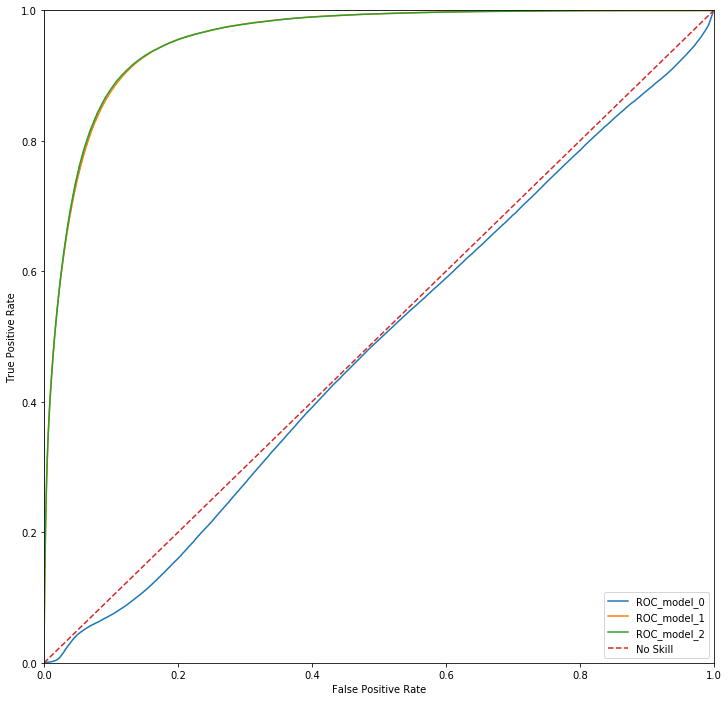

In [30]:
roc_comparison([preds, preds_new, preds_new_1], true_labels)

In [55]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(preds_new.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(test_gen.labels[:,i], preds_new[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/home/ilambda/.conda/envs/tf20/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


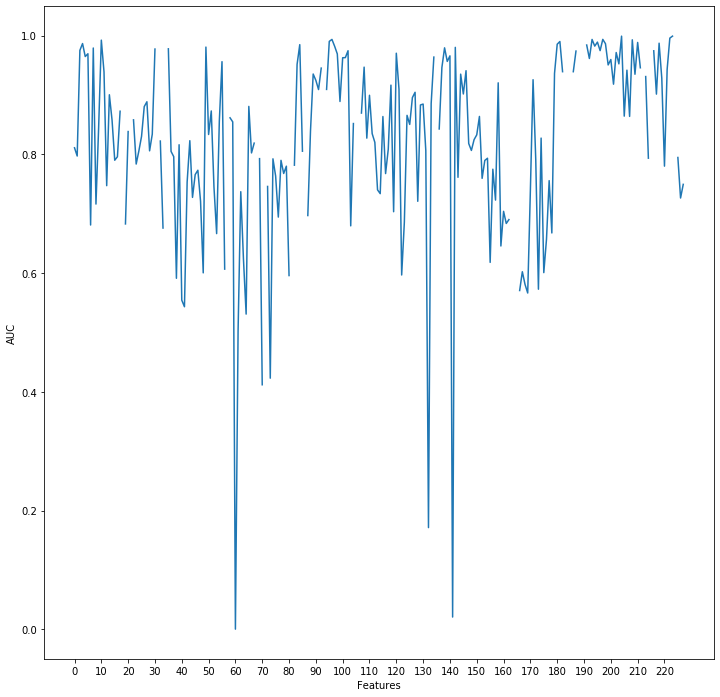

In [73]:
plt.figure(figsize=(12,12))
plt.plot(list(np.nan_to_num(roc_auc.values())))
plt.ylabel("AUC")
plt.xlabel("Features")
plt.xticks(ticks = [i for i in range(0,len(roc_auc.values()),10)], labels=[i for i in range(0,len(roc_auc.values()),10)])
plt.show()

/home/ilambda/.conda/envs/tf20/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


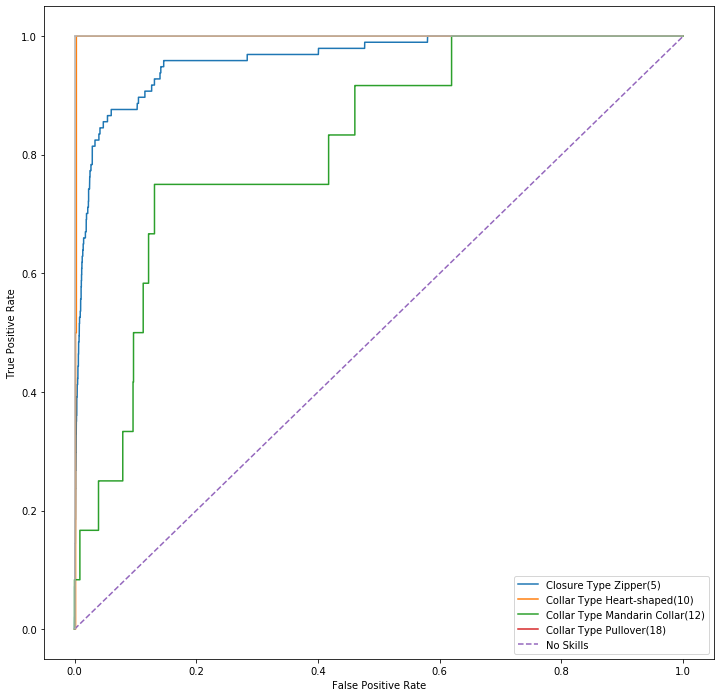

In [50]:
plot_roc_for_feature_id([5, 10, 12, 18], true_labels, preds_new_1, decode_features_map)

In [33]:
preds_new_1_classifications = result_classifications(true_labels, preds_new_1)

In [35]:
preds_new_classifications = result_classifications(true_labels, preds_new)

In [34]:
preds_new_1_classifications

{0: (932, 4978, 213, 5330),
 1: (12, 10269, 5, 1167),
 2: (0, 11330, 1, 122),
 3: (5, 11332, 0, 116),
 4: (36, 11142, 10, 265),
 5: (1, 11356, 0, 96),
 6: (0, 11428, 0, 25),
 7: (0, 11450, 0, 3),
 8: (0, 11442, 0, 11),
 9: (5, 11323, 0, 125),
 10: (0, 11449, 2, 2),
 11: (22, 11336, 25, 70),
 12: (0, 11441, 0, 12),
 13: (16, 11305, 25, 107),
 14: (2959, 6026, 1098, 1370),
 15: (5, 11056, 33, 359),
 16: (0, 11405, 0, 48),
 17: (2, 11332, 0, 119),
 18: (0, 0, 0, 0),
 19: (0, 11416, 0, 37),
 20: (1, 11375, 2, 75),
 21: (0, 0, 0, 0),
 22: (72, 10986, 51, 344),
 23: (0, 11396, 0, 57),
 24: (3, 11110, 7, 333),
 25: (4, 11210, 9, 230),
 26: (0, 11351, 5, 97),
 27: (190, 10559, 75, 629),
 28: (1, 11410, 0, 42),
 29: (1075, 8117, 361, 1900),
 30: (4, 11427, 1, 21),
 31: (0, 0, 0, 0),
 32: (0, 11206, 0, 247),
 33: (0, 11436, 0, 17),
 34: (0, 0, 0, 0),
 35: (1, 11432, 1, 19),
 36: (13, 10673, 8, 759),
 37: (0, 11436, 2, 15),
 38: (0, 11444, 0, 9),
 39: (279, 9789, 170, 1215),
 40: (0, 11445, 0, 8)

In [44]:
pres_rec_preds_new_1 = calculate_pres_recall(true_labels, preds_new_1, preds_new_1_classifications)

In [45]:
pres_rec_preds_new_1

{0: (0.8139737991266376, 0.14883423826253592),
 1: (0.7058823529411765, 0.010178117048346057),
 2: (0.0, 0.0),
 3: (1.0, 0.04132231404958678),
 4: (0.782608695652174, 0.11960132890365449),
 5: (1.0, 0.010309278350515464),
 6: (nan, 0.0),
 7: (nan, 0.0),
 8: (nan, 0.0),
 9: (1.0, 0.038461538461538464),
 10: (0.0, 0.0),
 11: (0.46808510638297873, 0.2391304347826087),
 12: (nan, 0.0),
 13: (0.3902439024390244, 0.13008130081300814),
 14: (0.7293566674882919, 0.6835296835296836),
 15: (0.13157894736842105, 0.013736263736263736),
 16: (nan, 0.0),
 17: (1.0, 0.01652892561983471),
 18: (nan, nan),
 19: (nan, 0.0),
 20: (0.3333333333333333, 0.013157894736842105),
 21: (nan, nan),
 22: (0.5853658536585366, 0.17307692307692307),
 23: (nan, 0.0),
 24: (0.3, 0.008928571428571428),
 25: (0.3076923076923077, 0.017094017094017096),
 26: (0.0, 0.0),
 27: (0.7169811320754716, 0.231990231990232),
 28: (1.0, 0.023255813953488372),
 29: (0.7486072423398329, 0.36134453781512604),
 30: (0.8, 0.16),
 31: (nan

### Custom generator

In [10]:
import os

In [11]:
def test_gen():
    indices = testing_df.index
    for i in indices:
        f = testing_df.iloc[i]['filename']
        label = testing_df.iloc[i][label_columns].values.astype(np.float32)
        filename = os.path.join(TEST_IMAGE_PATH,f)
        img = keras.preprocessing.image.load_img(filename, target_size=IMAGE_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = keras.applications.resnet.preprocess_input(img)
        img = img/255
        img = np.expand_dims(img, axis=0)
        
        yield(img, label)
